# 프로젝트: 인물모드 문제점 찾기

## Step 1: 인물모드 직접 해보기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

from collections import defaultdict

In [2]:

sample_img_path = './data/sample_image.png'
my_image_path_1 = './data/my_image_1.jpg'
my_image_path_2 = './data/my_image_2.jpg'
my_image_path_3 = './data/my_image_3.jpg'

sample_img = cv2.imread(sample_img_path)
print(sample_img.shape)

my_image_path_list = [my_image_path_1,my_image_path_2,my_image_path_3]
my_image_dict = defaultdict(int)

IMG_RANGE = range(1,4)

for i in IMG_RANGE:
    my_image_dict[i] = cv2.imread(my_image_path_list[i-1])
    print(my_image_dict[i].shape)


(415, 716, 3)
(1440, 1080, 3)
(1908, 4032, 3)
(4032, 1908, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = './models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ./models
model loaded successfully!


In [5]:
my_image_resized_dict = defaultdict(int)
my_image_seg_map_dict = defaultdict(int)

for i in IMG_RANGE:    
    img_resized, seg_map = MODEL.run(my_image_dict[i])
    print (my_image_dict[i].shape, img_resized.shape, seg_map.max())
    my_image_resized_dict[i] = img_resized
    my_image_seg_map_dict[i] = seg_map

(1440, 1080, 3) (513, 384, 3) 15
(1908, 4032, 3) (242, 513, 3) 19
(4032, 1908, 3) (513, 242, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 인물 마스크

In [7]:
my_image_mask_dict = defaultdict(int)
def make_seg_map_mask(key,img_resized,seg_map):
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    my_image_seg_map_dict[key] = seg_map
    
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    my_image_mask_dict[key] = img_mask

    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

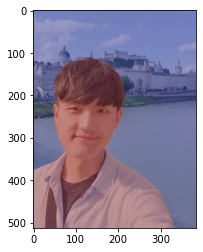

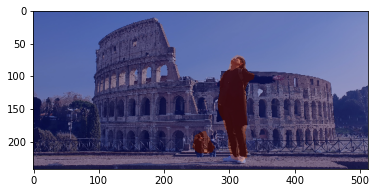

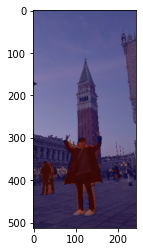

In [11]:
for i in IMG_RANGE:
    make_seg_map_mask(i, my_image_resized_dict[i],my_image_seg_map_dict[i])

### 인물 배경 분리

In [14]:
my_image_mask_up_dict = defaultdict(int)

def make_mask_original_size(key, img_mask,img_orig):
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    my_image_mask_up_dict[key] = img_mask_up
    
    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

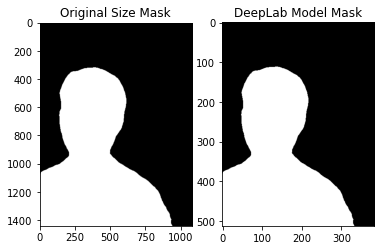

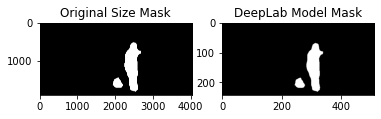

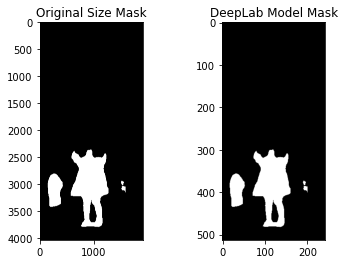

In [15]:
for i in IMG_RANGE:
    make_mask_original_size(i,my_image_mask_dict[i],my_image_dict[i])

### 배경 복원

In [22]:
my_image_bg_dict = defaultdict(int)
my_image_mask_color_dict = defaultdict(int)
def get_bg_img(key,img_mask_up,img_orig):
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    my_image_mask_color_dict[key] = img_mask_color

    img_bg_mask = cv2.bitwise_not(img_mask_color)

    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    my_image_bg_dict[key] = img_bg

    plt.imshow(img_bg)
    plt.show()

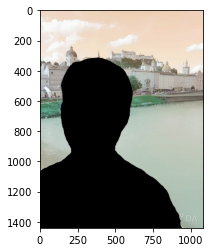

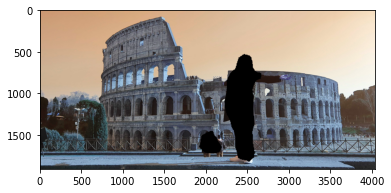

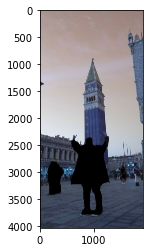

In [23]:
for i in IMG_RANGE:
    get_bg_img(i,my_image_mask_up_dict[i],my_image_dict[i])

### 배경 흐리게

In [24]:
my_image_bg_blur_dict = defaultdict(int)
def make_bg_blur(key, img_bg):
    img_bg_blur = cv2.blur(img_bg, (13,13))
    my_image_bg_blur_dict[key] = img_bg_blur
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

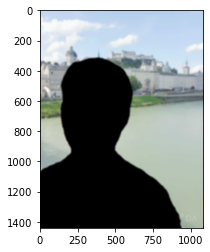

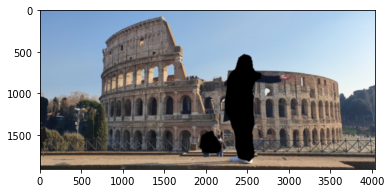

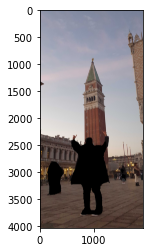

In [25]:
for i in IMG_RANGE:
    make_bg_blur(i,my_image_bg_dict[i])

### 흐린 배경과 사람 합치기

In [26]:
my_image_concat_dict = defaultdict(int)
def combine_orig_bg_blur(key,img_mask_color,img_bg_blur,img_orig):
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    my_image_concat_dict[key] = img_concat
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

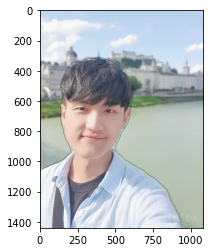

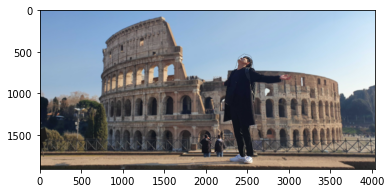

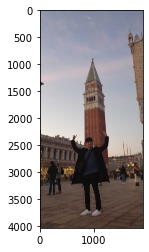

In [27]:
for i in IMG_RANGE:
    combine_orig_bg_blur(i,my_image_mask_color_dict[i],my_image_bg_blur_dict[i],my_image_dict[i])

### 원본 이미지와 비교

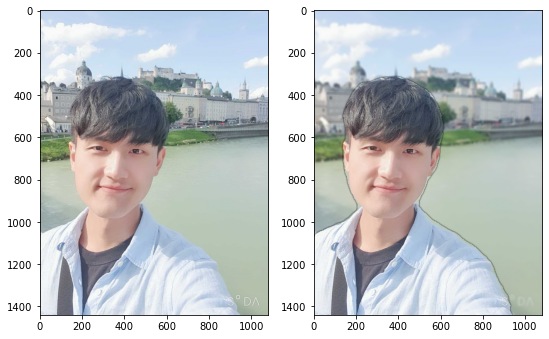

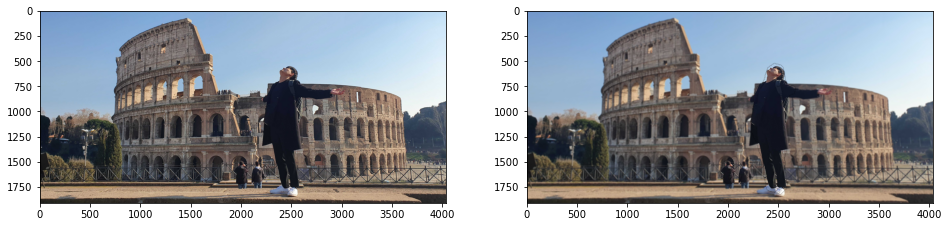

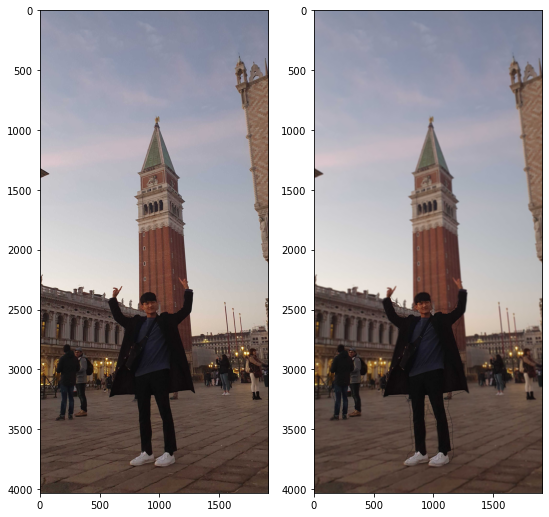

In [33]:
# my_image_dict
# my_image_concat_dict

for i in IMG_RANGE:
    if i==2:
        figsize = (16,16)
    else:
        figsize = (9,12)
    f,axes = plt.subplots(nrows=1,ncols=2,figsize=figsize)
    axes[0].imshow(cv2.cvtColor(my_image_dict[i], cv2.COLOR_BGR2RGB))
    axes[1].imshow(cv2.cvtColor(my_image_concat_dict[i], cv2.COLOR_BGR2RGB)) 
    plt.show()

## Step 2:사진에서 문제점 찾기

### 내 사진에서 문제점
1. 인물 주변으로 희미한 검은 선이 함께 생성된다.
2. 나 아닌 다른 사람도 사람으로 인식하고 그 사람도 선명하게 표현하는 대상으로 지정한다.
3. 신체 일부(손)를 사람으로 인식하지 않기도 한다.
4. 두 번째, 세 번째 사진의 경우 배경이 비교적 덜 흐릿해졌다.

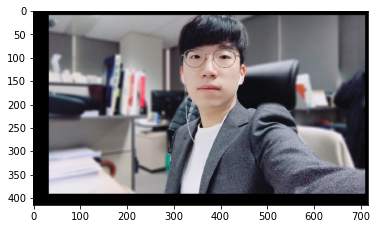

In [37]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

### 예시 사진에서 문제점
1. 이어폰 줄이 끊어진 것으로 표현된다.
2. 입고있는 옷의 일부가 배경처럼 흐리게 처리된다.
3. 이미지 기준으로 왼쪽에 있는 귀가 배경으로 처리된것으로 보인다.

## Step 3:해결 방법을 제안해보기 (사용 가능한 방법 공부)
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

### 피사계심도에 대한 이해
https://ggyul.tistory.com/12

바늘구멍이 작을수록(조리개 값이 클 수록) 받아들이는 빛의 양이 작으면서 촛점이 명확하며, 바늘구멍이 클수록(조리개 값이 낮을수록) 빛의 양이 많아지며 촛점이 흐려지게 된다.

### 3D Depth Camera 활용하기
https://m.blog.naver.com/panoptics/221336152952

픽셀의 깊이 정보를 습득할 수 있음.
사물을 입체적으로 찍고 표현함을 넘어 같은 위치 내에서 다른 높이 또는 깊이를 측정하는 실내 맵핑, 증강 현실 구현, 사람의 몸짓 및 동작을 인식하는 인터페이스의 개발, 가상현실, 증강현실, 자율주행 드론, 로봇 및 자동차 개발에 활발히 사용될 수 있다. 

3D 깊이 인식 기술은 크게 스테레오, ToF, Structured Pattern 세 가지 방식으로 나뉜다.
하이브리드 방식도 존재.

(1) 스테레오 : 두 개의 2D 이미지 센서를 결합해서 만든 입체 영상.
(2) ToF(Time of Flight) : 장면의 모든 픽셀에 대한 변조된 **광 신호의 지연 또는 위상 시프트를 측정**하여 이동 시간 정보를 획득. 일반적으로 이 광 신호는 인간의 시력을 방해하지 않도록 스펙트럼의 근적외선 부분에 위치. 시스템의 ToF 센서는 각 픽셀이 장면까지의 거리를 결정할 수 있는 픽셀 배열로 구성.
(3) Structured Patter : 구조화된 빛의 패턴을 투사. 결과 이미지를 캡처.

### 깊이 영상(Depth Image)활용하기
https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
https://sites.google.com/view/struct2depth

(1) Monodepth2
https://www.youtube.com/watch?v=jI1Qf7zMeIs&ab_channel=ComputerVisionFoundationVideos

(2) Monodepth2 Extension: Struct2Depth
LiDAR 없이도 segmentation을 동반한 depth sensor가 가능함을 보여주었다.
Learning the motion transforms for individual objects and enforcing photometric consistency among other losses.


### IR(적외선)을 활용한 사례
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.
https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html

uDepth is part of the family of dense local stereo matching techniques, which estimate parallax computationally for each pixel. These techniques evaluate a region surrounding each pixel in the image formed by one camera, and try to find a similar region in the corresponding image from the second camera.
양쪽 눈을 번갈아가며 감았다 떴을 때, 물체에서 명확히 보이는 부분이 변경(shift)할 것! 이 효과(parallax)를 활용하여 depth 를 reconstruct 한다.



## 제안해보기

3D Depth Camera 기술 중 스트레오 방식에서 활용되고, Monodepth2 에서도 사용되는 방식인 parallax 를 계산하는 개념을 활용할 수 있을 것으로 생각된다.
이미지 전처리 과정에서 이미지의 경계 부분 이미지 픽셀을 parallax를 처리하는 아이디어를 활용하여 보다 명확한 depth를 얻어낸다면, 더 좋은 이미지 mask를 얻어낼 수 있을 것이라고 생각된다.